# Projective representation ADAM gradient descent sweep

Created 07/11/2024

Objectives:
* Apply algorithm from "proj_rep_gradient_descent_sweep" notebook to find projective representation unitaries across a range of cases, and hence extract SPT phase. This time use ADAM gradient descent.

# Package imports

In [1]:
import sys
sys.path.append('../../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

In [4]:
from functools import reduce 

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [14]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [15]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [16]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [17]:
NUM_SITES = 6

In [18]:
e, a, b, c = symmetry_labels

In [19]:
group_products = [
    (a, a, e),
    (b, b, e),
    (c, c, e),
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

## Functions

In [20]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [21]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [22]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [23]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [24]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [25]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [26]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [27]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [28]:
def get_random_unitary_operator(mps_tensor, dim):
    # To-do: automate getting dimension
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)
    p_leg_conj = mps_tensor.get_leg(p_leg_label_conj)

    X = scipy.stats.unitary_group.rvs(dim)

    out = npc.Array.from_ndarray(
        X,
        legcharges=[p_leg, p_leg_conj],
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [29]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

### Gradients

In [30]:
def unitarity_gradient(matrix, grouped_physical_leg_label='p',
                      grouped_physical_leg_conj_label='p*'):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())

    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    return (t - matrix, score_2, score_4)

In [31]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [32]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [33]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [34]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

In [35]:
def update(matrix, reduced_density_matrix, unitarity_scores, overlap_scores,
           target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, adam_optimizer, target=1):

    u_grad, u_score_2, u_score_4 = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    u_score = u_score_4 - 2*u_score_2 + matrix_dim
    unitarity_scores.append(u_score.real)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(overlap)

    target_score = (
        (overlap_lr/2.0)*(target - np.abs(overlap))**2 +
        (unitarity_lr/4.0)*u_score.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    adam_grad = adam_optimizer.update(gradient)
    matrix -= gradient

### Proj rep functions

In [36]:
IDENTITY_LABEL = 'II'

In [37]:
def update_grad_dict(grad_dict, group_element_label, value):
    if group_element_label in grad_dict:
        grad_dict[group_element_label] += value
    else:
        grad_dict[group_element_label] = value

In [38]:
def get_unitary_from_dict(unitary_dict, label, identity_label=IDENTITY_LABEL):
    if label == identity_label:
        return None
    else:
        return unitary_dict[label]

In [39]:
def update_grad_inverse_pair_case(unitary_1, unitary_2, group_label_1,
                               group_label_2, matrix_mul, grad_dict,
                               scores_dict, identity_label=IDENTITY_LABEL):
    u1, u2 = unitary_1, unitary_2
    
    u3 = matrix_mul(u1, u2)

    leg_labels = u3.get_leg_labels()

    c = npc.trace(u3, *leg_labels)
    c_normed = c/(np.abs(c))

    o1 = matrix_mul(u3, u2.conj())
    o2 = matrix_mul(u1.conj(), u3)

    grad_1 = o1 - c_normed*(u2.conj())
    grad_2 = o2 - c_normed*(u1.conj())

    update_grad_dict(grad_dict, group_label_1, grad_1)
    update_grad_dict(grad_dict, group_label_2, grad_2)

    s1 = npc.tensordot(o1, u1.conj(), [leg_labels, leg_labels[::-1]])
    s2 = np.abs(c)
    s3 = u3.shape[0]
    
    score = (s1 -2*s2 + s3).real

    scores_dict[(group_label_1, group_label_2, identity_label)] = score

In [40]:
def update_grad_generic_case(unitary_triple, group_label_triple, matrix_mul,
                          grad_dict, scores_dict):
    
    u_a, u_b, u_c = unitary_triple

    # Perform matrix multiplications in a way that's difficult to read but
    # ultimately reduces the number of matrix multiplications performed.
    u1 = matrix_mul(u_a, u_b)
    u2 = matrix_mul(u_a.conj(), u_c)
    u3 = matrix_mul(u_c, u_b.conj())

    u_triple = matrix_mul(u1, u_c.conj())
    u4 = matrix_mul(u_triple, u3)
    u5 = matrix_mul(u_a.conj(), u1)
    u6 = reduce(matrix_mul, [u5, u_c.conj(), u_c])
    u7 = matrix_mul(u3, u5)

    leg_labels = u_triple.get_leg_labels()

    c = npc.trace(u_triple, *leg_labels)
    c_normed = c/(np.abs(c))

    grads = [
        u4 - c_normed*u3,
        u6 - c_normed*u2,
        u7 - c_normed.conjugate()*u1
    ]

    for l, g in zip(group_label_triple, grads):
        update_grad_dict(grad_dict, l, g)
    
    s1 = npc.tensordot(u4, u_a.conj(), [leg_labels, leg_labels[::-1]])
    s2 = np.abs(c)
    s3 = u_triple.shape[0]
    
    score = (s1 -2*s2 + s3).real

    scores_dict[group_label_triple] = score

In [41]:
def update_grad(unitary_dict, group_label_triple, matrix_mul, grad_dict,
                scores_dict, identity_label=IDENTITY_LABEL):
    u_a, u_b, u_c = [
        get_unitary_from_dict(unitary_dict, g)
        for g in group_label_triple
    ]

    if u_c is None:
        update_grad_inverse_pair_case(
            u_a,
            u_b,
            group_label_triple[0],
            group_label_triple[1],
            matrix_mul,
            grad_dict,
            scores_dict,
            identity_label
        )
    else:
        update_grad_generic_case(
            (u_a, u_b, u_c),
            group_label_triple,
            matrix_mul,
            grad_dict,
            scores_dict
        )

In [42]:
# Unused functions
def get_grad_first_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_c, u_b.conj())

    u_2 = reduce(matrix_mul, [u_a, u_b, u_c.conj(), u_1])

    return u1 - trace_phase*u_2

def get_grad_second_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_a.conj(), u_c)

    u_2 = reduce(matrix_mul, [u_a.conj(), u_a, u_b, u_c.conj(), u_c])

    return u1 - trace_phase*u_2

def get_grad_third_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_a, u_b)

    u_2 = reduce(matrix_mul, [u_c, u_b.conj(), u_a.conj(), u_1])

    return u1 - trace_phase.conjugate()*u_2

grad_element_functions = [
    get_grad_first_element,
    get_grad_second_element,
    get_grad_third_element
]

In [43]:
def get_proj_rep_grad(unitary_dict, group_label_triples, physical_leg_label,
             physical_leg_conj_label, identity_label=IDENTITY_LABEL):
    
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [[physical_leg_label,], [physical_leg_conj_label,]]
        )

    grad_dict = dict()
    scores_dict = dict()

    for group_label_triple in group_label_triples:
        update_grad(
            unitary_dict,
            group_label_triple,
            matrix_multiplication,
            grad_dict,
            scores_dict,
            identity_label=IDENTITY_LABEL
        )

    score = sum(scores_dict.values())

    return grad_dict, score

In [44]:
def get_reduced_density_matrix(symmetry_case, num_sites=NUM_SITES, normalise=False):
    mps_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    rdm = symmetry_case.right_projected_symmetry_state

    if normalise:
        normalisation = npc.trace(rdm, 'vR', 'vR*')
        norm_phase = normalisation/np.abs(normalisation)
    
        rdm *= norm_phase.conj()

    for i, b in enumerate(mps_tensors):
        b_current = b.replace_label('p', f'p{i}')
    
        rdm = npc.tensordot(rdm, b_current, [['vR'], ['vL']])
        rdm = npc.tensordot(rdm, b_current.conj(), [['vR*'], ['vL*']])
    
    rdm = npc.trace(rdm, 'vR', 'vR*')

    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    rdm = rdm.combine_legs([leg_labels, leg_conj_labels])

    return rdm

In [45]:
def get_grouped_leg_labels(num_sites):
    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
    grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

    return (grouped_physical_leg_label, grouped_physical_leg_conj_label)

In [46]:
def multiply_tenpy_matrices(m1, m2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    return npc.tensordot(
        m1,
        m2,
        [
            [grouped_physical_leg_label,],
            [grouped_physical_leg_conj_label,]
        ]
    )

In [47]:
def get_overlap_target(symmetry_case):
    singular_val = symmetry_case.symmetry_transfer_matrix_singular_vals[0]
    target = np.power(singular_val, -1/2)

    return target

In [48]:
def initalize_optimization(symmetry_cases, num_sites, adam_params,
                           adam_kw_params, random_initialisation=False):

    # Don't forget to only pass in symmetry_cases without identity!
    # Should maybe allow for identity as well...?

    reduced_density_matrices = {
        l: get_reduced_density_matrix(c, num_sites)
        for l, c in zip(symmetry_labels[1:], symmetry_cases)
    }

    overlap_targets = {
        l: get_overlap_target(c)
        for l, c in zip(symmetry_labels[1:], symmetry_cases)
    }

    leg_label, leg_conj_label = get_grouped_leg_labels(num_sites)

    # Assuming spin 1/2
    matrix_dim = 2**num_sites

    if random_initialisation:
        solutions_dict = {
            l: get_random_unitary_operator(rdm, matrix_dim)
            for l, rdm in reduced_density_matrices.items()
        }
    else:
        solutions_dict = {
            l: get_identity_operator(rdm)
            for l, rdm in reduced_density_matrices.items()
        }

    unitarity_scores = {l:list() for l in symmetry_labels[1:]}
    overall_unitarity_scores = list()
    overlap_scores = {l:list() for l in symmetry_labels[1:]}
    overall_target_overlap_scores = list()
    proj_rep_scores = list()
    # Be clearer with names?
    cost_function_scores = list()

    # Implement checks...?

    adam_optimizers_dict = dict()

    for l in reduced_density_matrices:
        opt = AdamTenpy(*adam_params, **adam_kw_params)
        adam_optimizers_dict[l] = opt

    return (
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores,
        adam_optimizers_dict
    )

In [49]:
def get_unitarity_gradients(solutions_dict, matrix_dim, leg_label,
                            leg_conj_label):
    grad_score_triples = {
        l: unitarity_gradient(v, leg_label, leg_conj_label)
        for l, v in solutions_dict.items()
    }

    grads = {l: t[0] for l, t in grad_score_triples.items()}

    get_u_score = lambda t: (t[2] - 2*t[1] + matrix_dim).real

    scores = {l: get_u_score(t) for l, t in grad_score_triples.items()}

    return grads, scores

In [50]:
def get_overlap_gradients(solutions_dict, reduced_density_matrices,
                          overlap_targets, leg_label, leg_conj_label):
    grads = dict()
    scores = dict()

    for label, sol in solutions_dict.items():
        rdm = reduced_density_matrices[label]
        overlap_target = overlap_targets[label]

        gradient, overlap_score = overlap_gradient(
            sol,
            rdm,
            leg_label,
            leg_conj_label,
            target=overlap_target
        )

        grads[label] = gradient
        scores[label] = overlap_score

    return grads, scores

In [51]:
def update_once(reduced_density_matrices, overlap_targets, leg_label,
                leg_conj_label, matrix_dim, solutions_dict, unitarity_scores,
                overall_unitarity_scores, overlaps,
                overall_target_overlap_scores, proj_rep_scores,
                cost_function_scores, group_label_triples, unitarity_lr,
                overlap_lr, proj_rep_lr, adam_optimizers_dict):


    unitarity_grads, current_u_scores = get_unitarity_gradients(
        solutions_dict, matrix_dim,leg_label, leg_conj_label
    )

    for l, s in current_u_scores.items():
        unitarity_scores[l].append(s)

    current_u_score = sum(current_u_scores.values())
    overall_unitarity_scores.append(current_u_score)

    overlap_grads, current_overlaps = get_overlap_gradients(
        solutions_dict,
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label
    )

    for l, s in current_overlaps.items():
        overlaps[l].append(np.abs(s))

    overlap_target_score = sum(
        (overlap_targets[l] - np.abs(current_overlaps[l]))**2
        for l in current_overlaps
    )

    overall_target_overlap_scores.append(overlap_target_score)

    # Proj rep case
    proj_rep_grads, proj_rep_score = get_proj_rep_grad(
        solutions_dict,
        group_label_triples,
        leg_label,
        leg_conj_label,
        identity_label=IDENTITY_LABEL
    )

    proj_rep_scores.append(proj_rep_score)

    cost_function_score = (
        (overlap_lr/2.0)*overlap_target_score +
        (unitarity_lr/4.0)*current_u_score +
        (proj_rep_lr)*proj_rep_score
    )
        
    cost_function_scores.append(cost_function_score)

    # Update each unitary
    for l in solutions_dict:
        grad = (
            unitarity_lr*unitarity_grads[l]
            + overlap_lr*overlap_grads[l]
            + proj_rep_lr*proj_rep_grads[l]
        )

        adam_grad = adam_optimizers_dict[l].update(grad)

        solutions_dict[l] -= adam_grad

In [52]:
def repeat_update(reduced_density_matrices, overlap_targets, leg_label,
                leg_conj_label, matrix_dim, solutions_dict, unitarity_scores,
                overall_unitarity_scores, overlaps,
                overall_target_overlap_scores, proj_rep_scores,
                cost_function_scores, group_label_triples, unitarity_lr,
                overlap_lr, proj_rep_lr, adam_optimizers_dict,
                num_iterations):

    for _ in range(num_iterations):
        update_once(
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlaps,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores,
            group_label_triples,
            unitarity_lr,
            overlap_lr,
            proj_rep_lr,
            adam_optimizers_dict
        )

### Sweep function

# Tests

## B=0, 2 sites

In [104]:
num_sites = 2
num_random_initializations = 5
num_gd_iterations = 200

unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

adam_params = (1e-2, 0.3, 0.3)

In [105]:
def proj_rep_unitary_extraction(symmetry_cases):
    current_best_score = 10e10

    for _ in range(num_random_initializations):
        initial_params = initalize_optimization(
            symmetry_cases,
            num_sites,
            adam_params,
            {},
            random_initialisation=True
        )

        (
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores,
            adam_optimizers_dict
        ) = initial_params

        repeat_update(
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores,
            group_products,
            unitarity_lr,
            overlap_lr,
            proj_rep_lr,
            adam_optimizers_dict,
            num_gd_iterations
        )

        if cost_function_scores[-1] < current_best_score:
            best_solutions_dict = solutions_dict
            best_unitarity_scores = unitarity_scores
            best_overall_unitarity_scores = overall_unitarity_scores
            best_overlap_scores = overlap_scores
            best_overall_target_overlap_scores = overall_target_overlap_scores
            best_proj_rep_scores = proj_rep_scores
            best_cost_function_scores = cost_function_scores

    return (
        best_solutions_dict,
        best_unitarity_scores,
        best_overall_unitarity_scores,
        best_overlap_scores,
        best_overall_target_overlap_scores,
        best_proj_rep_scores,
        best_cost_function_scores
    )

In [106]:
out = proj_rep_unitary_extraction(cases[0][1:])

In [107]:
(
        best_solutions_dict,
        best_unitarity_scores,
        best_overall_unitarity_scores,
        best_overlap_scores,
        best_overall_target_overlap_scores,
        best_proj_rep_scores,
        best_cost_function_scores
) = out

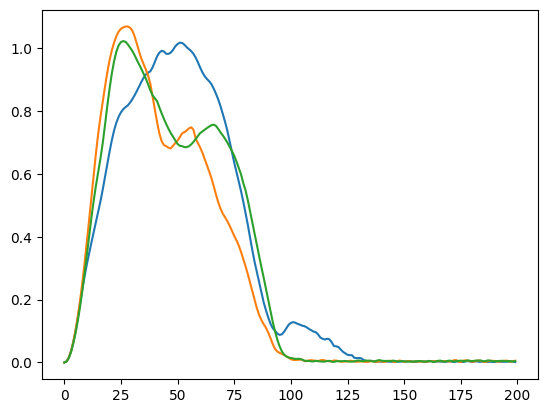

In [108]:
for X in best_unitarity_scores.values():
    plt.plot(X)

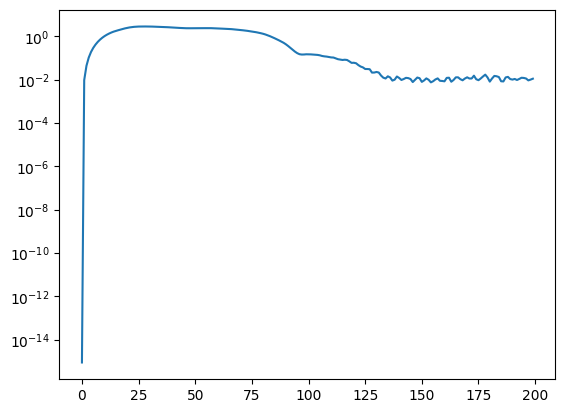

In [109]:
plt.plot(best_overall_unitarity_scores)
plt.yscale('log')

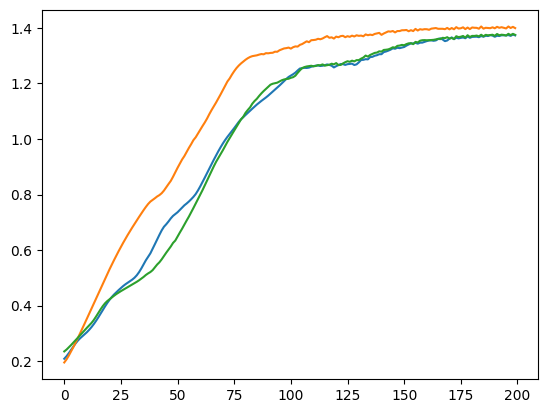

In [110]:
for X in best_overlap_scores.values():
    plt.plot(X)

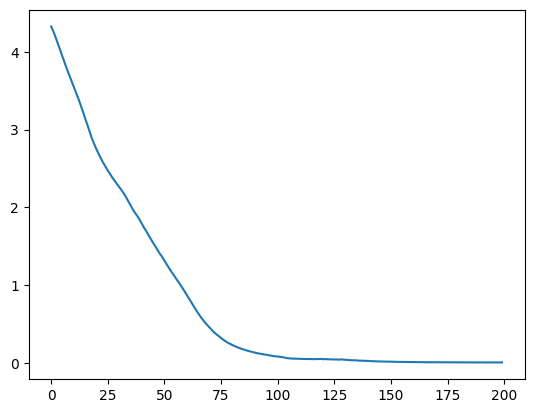

In [111]:
plt.plot(best_overall_target_overlap_scores)

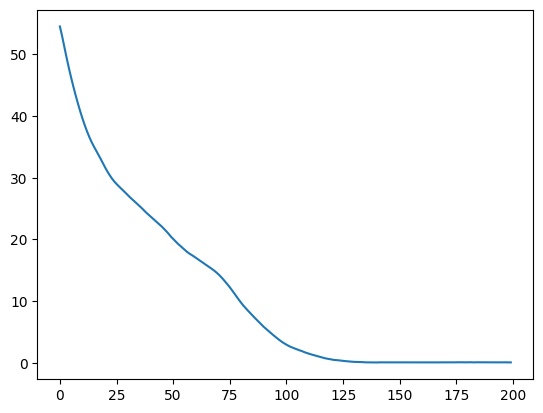

In [112]:
plt.plot(best_proj_rep_scores)

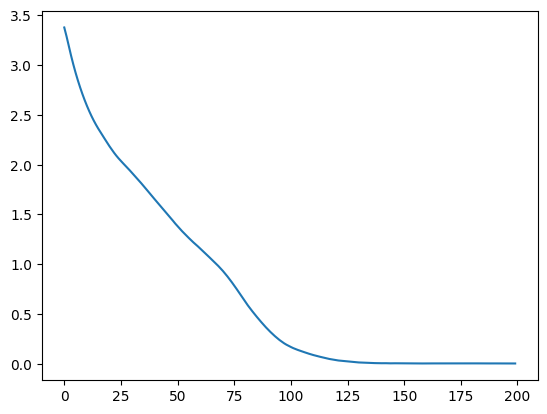

In [113]:
plt.plot(best_cost_function_scores)

In [114]:
best_cost_function_scores[-1]

0.004378624981938935

## B=0, 5 sites

In [156]:
num_sites = 5
num_random_initializations = 100
num_gd_iterations = 200

unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

adam_params = (1e-2, 0.3, 0.3)

In [157]:
def proj_rep_unitary_extraction(symmetry_cases):
    current_best_score = 10e10

    for _ in range(num_random_initializations):
        initial_params = initalize_optimization(
            symmetry_cases,
            num_sites,
            adam_params,
            {},
            random_initialisation=True
        )

        (
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores,
            adam_optimizers_dict
        ) = initial_params

        repeat_update(
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores,
            group_products,
            unitarity_lr,
            overlap_lr,
            proj_rep_lr,
            adam_optimizers_dict,
            num_gd_iterations
        )

        if cost_function_scores[-1] < current_best_score:
            best_solutions_dict = solutions_dict
            best_unitarity_scores = unitarity_scores
            best_overall_unitarity_scores = overall_unitarity_scores
            best_overlap_scores = overlap_scores
            best_overall_target_overlap_scores = overall_target_overlap_scores
            best_proj_rep_scores = proj_rep_scores
            best_cost_function_scores = cost_function_scores

    return (
        best_solutions_dict,
        best_unitarity_scores,
        best_overall_unitarity_scores,
        best_overlap_scores,
        best_overall_target_overlap_scores,
        best_proj_rep_scores,
        best_cost_function_scores
    )

In [158]:
out = proj_rep_unitary_extraction(cases[0][1:])

In [159]:
(
        best_solutions_dict,
        best_unitarity_scores,
        best_overall_unitarity_scores,
        best_overlap_scores,
        best_overall_target_overlap_scores,
        best_proj_rep_scores,
        best_cost_function_scores
) = out

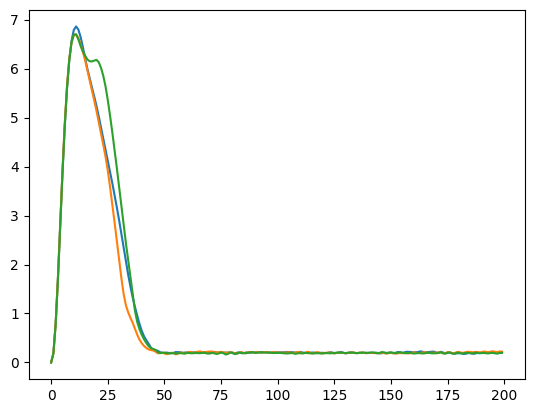

In [160]:
for X in best_unitarity_scores.values():
    plt.plot(X)

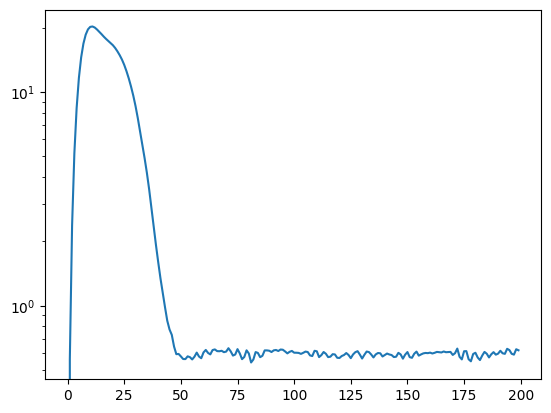

In [161]:
plt.plot(best_overall_unitarity_scores)
plt.yscale('log')

In [162]:
best_overall_unitarity_scores[-1]

0.6184976916152607

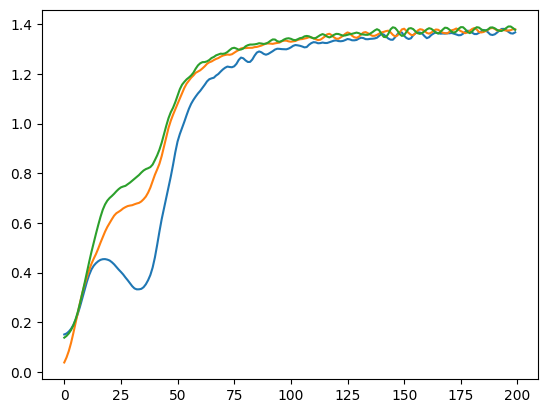

In [163]:
for X in best_overlap_scores.values():
    plt.plot(X)

In [170]:
[v[-1] for v in best_overlap_scores.values()]

[1.3669517815643095, 1.3790911056451884, 1.3771337661272076]

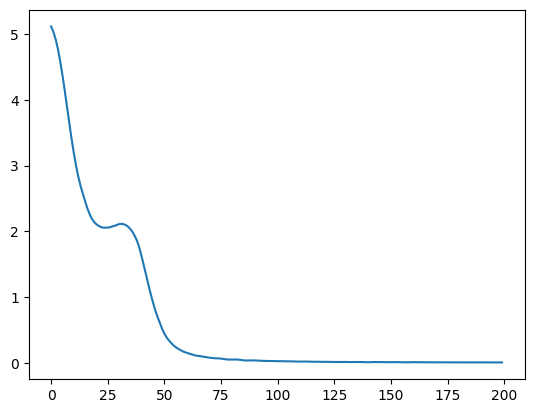

In [171]:
plt.plot(best_overall_target_overlap_scores)

In [166]:
best_overall_target_overlap_scores[-1]

0.004842174181458241

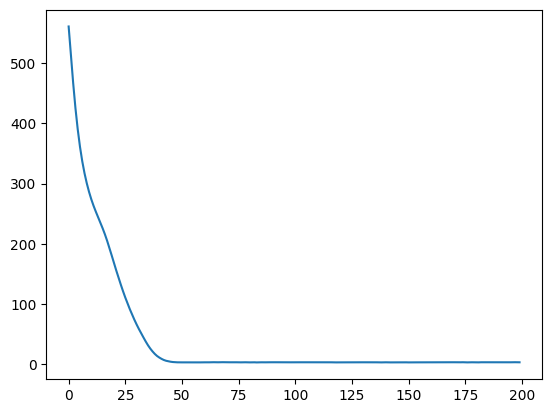

In [167]:
plt.plot(best_proj_rep_scores)

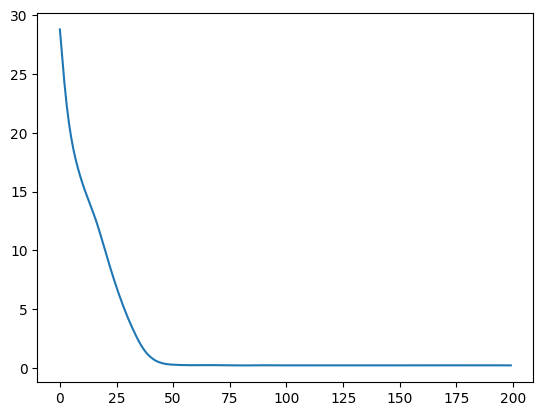

In [168]:
plt.plot(best_cost_function_scores)

In [169]:
best_cost_function_scores[-1]

0.22235564923409892

(Note I repeated this with more random initializations and got better results.)

### Extract SPT phase

In [174]:
best_solutions_dict

{'IX': <npc.Array shape=(32, 32) labels=['(p0.p1.p2.p3.p4)', '(p0*.p1*.p2*.p3*.p4*)']>,
 'XI': <npc.Array shape=(32, 32) labels=['(p0.p1.p2.p3.p4)', '(p0*.p1*.p2*.p3*.p4*)']>,
 'XX': <npc.Array shape=(32, 32) labels=['(p0.p1.p2.p3.p4)', '(p0*.p1*.p2*.p3*.p4*)']>}

In [175]:
def extract_proj_rep_phase_generic(u_a, u_b, u_c, leg_label, leg_conj_label):
    u1 = npc.tensordot(u_a, u_b, [[leg_label,], [leg_conj_label,]])
    tr = npc.tensordot(
        u1,
        u_c.conj(),
        [
            [leg_label, leg_conj_label],
            [leg_conj_label, leg_label]
        ]
    )

    dim = u1.shape[0]

    return tr/dim

In [176]:
def extract_proj_rep_phase_inverse_pair(u_a, u_b, leg_label, leg_conj_label):
    tr = npc.tensordot(
        u_a,
        u_b,
        [
            [leg_label, leg_conj_label],
            [leg_conj_label, leg_label]
        ]
    )

    dim = u_a.shape[0]

    return tr/dim

In [178]:
def extract_proj_rep_phase(unitary_dict, group_label_triple, leg_label,
                           leg_conj_label):

    u_a, u_b, u_c = [
        get_unitary_from_dict(unitary_dict, l)
        for l in group_label_triple
    ]

    if u_c is None:
        return extract_proj_rep_phase_inverse_pair(
            u_a, u_b, leg_label, leg_conj_label
        )
    else:
        return extract_proj_rep_phase_generic(
            u_a, u_b, u_c, leg_label, leg_conj_label
        )

In [179]:
proj_rep_phases = {
    triple: extract_proj_rep_phase(
        best_solutions_dict,
        triple,
        '(p0.p1.p2.p3.p4)',
        '(p0*.p1*.p2*.p3*.p4*)'
    )
    for triple in group_products
}

In [181]:
from itertools import combinations

In [184]:
non_trivial_pairs = list(combinations(symmetry_labels[1:], 2))

In [182]:
def first_pair_agree(triple, pair):
    if triple[:2] == pair:
        return True
    elif triple[1::-1] == pair:
        return True
    else:
        return False

def get_gauge_invariant_phase(phase_dict, group_label_pair):
    phases = [
        v
        for k, v in phase_dict.items()
        if first_pair_agree(k, group_label_pair)
    ]

    assert len(phases) == 2

    return phases[1]/phases[0]

In [185]:
phases = [
    get_gauge_invariant_phase(proj_rep_phases, pair)
    for pair in non_trivial_pairs
]

In [186]:
phases

[(-1.000103128908488-2.6458567978532018e-05j),
 (-0.9998027161020469+0.0003800568836807341j),
 (-0.9997787885884764+7.787912241660743e-05j)]

## B=0.9, 5 sites

In [192]:
num_sites = 5
num_random_initializations = 100
num_gd_iterations = 200

unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

adam_params = (1e-2, 0.3, 0.3)

In [193]:
out = proj_rep_unitary_extraction(cases[8][1:])

In [194]:
(
        best_solutions_dict,
        best_unitarity_scores,
        best_overall_unitarity_scores,
        best_overlap_scores,
        best_overall_target_overlap_scores,
        best_proj_rep_scores,
        best_cost_function_scores
) = out

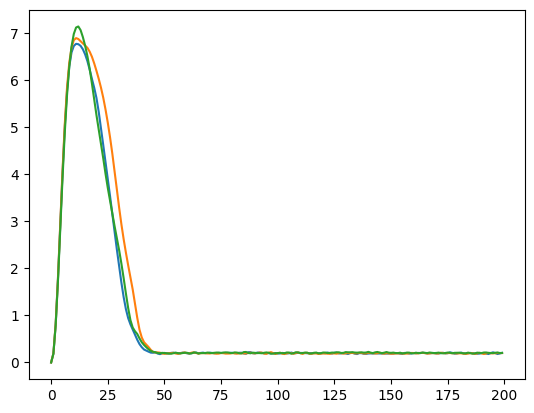

In [195]:
for X in best_unitarity_scores.values():
    plt.plot(X)

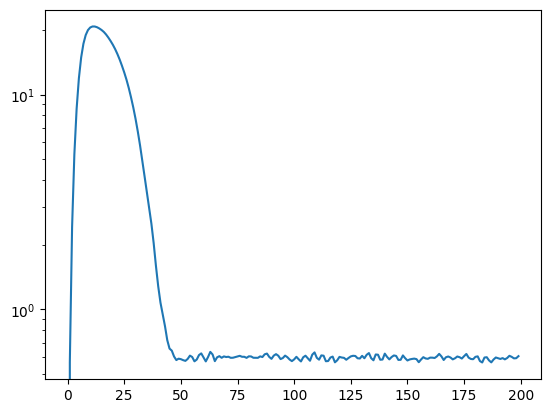

In [196]:
plt.plot(best_overall_unitarity_scores)
plt.yscale('log')

In [197]:
best_overall_unitarity_scores[-1]

0.6065662767105238

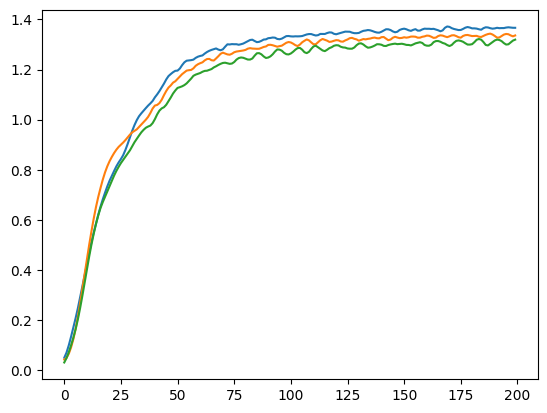

In [198]:
for X in best_overlap_scores.values():
    plt.plot(X)

In [199]:
[v[-1] for v in best_overlap_scores.values()]

[1.366802155533502, 1.336226545737797, 1.3195430118895621]

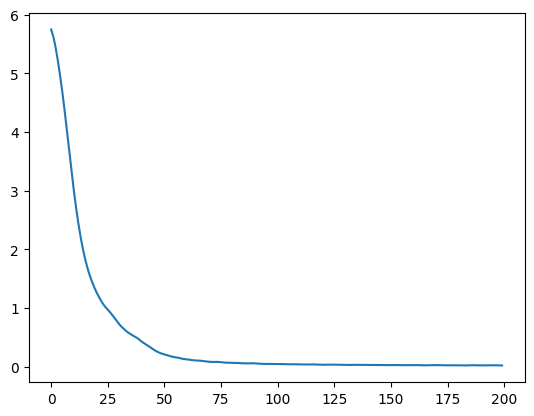

In [200]:
plt.plot(best_overall_target_overlap_scores)

In [201]:
best_overall_target_overlap_scores[-1]

0.02234675753543242

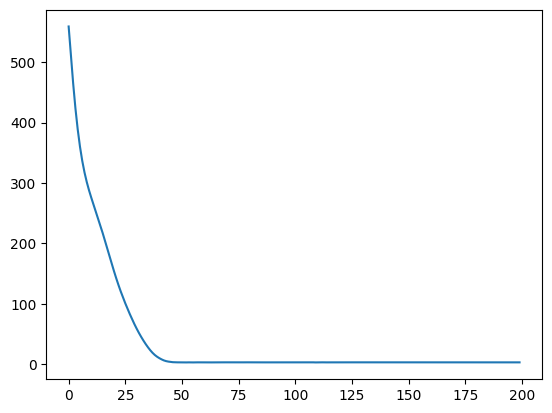

In [202]:
plt.plot(best_proj_rep_scores)

In [203]:
best_proj_rep_scores[-1]

3.455651321318431

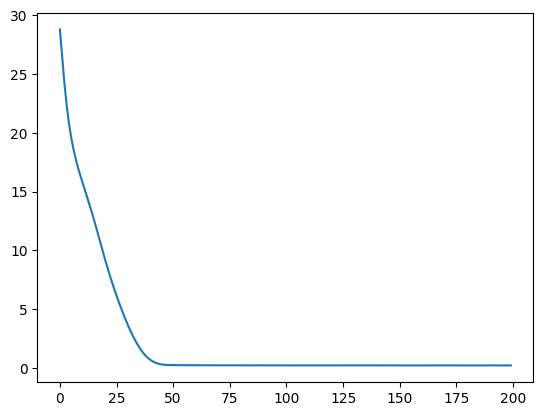

In [204]:
plt.plot(best_cost_function_scores)

In [205]:
best_cost_function_scores[-1]

0.22162705044952571

In [206]:
proj_rep_phases = {
    triple: extract_proj_rep_phase(
        best_solutions_dict,
        triple,
        '(p0.p1.p2.p3.p4)',
        '(p0*.p1*.p2*.p3*.p4*)'
    )
    for triple in group_products
}

In [207]:
phases = [
    get_gauge_invariant_phase(proj_rep_phases, pair)
    for pair in non_trivial_pairs
]

In [208]:
phases

[(-1.0007630648276142-0.0005092730131309454j),
 (-1.0003564879137121+0.00024859819796391663j),
 (-1.0000091562360436-2.788904164709192e-05j)]

## B=1.2, 5 sites

In [211]:
num_sites = 5
num_random_initializations = 100
num_gd_iterations = 200

unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

adam_params = (1e-2, 0.3, 0.3)

In [212]:
out = proj_rep_unitary_extraction(cases[11][1:])

In [213]:
(
        best_solutions_dict,
        best_unitarity_scores,
        best_overall_unitarity_scores,
        best_overlap_scores,
        best_overall_target_overlap_scores,
        best_proj_rep_scores,
        best_cost_function_scores
) = out

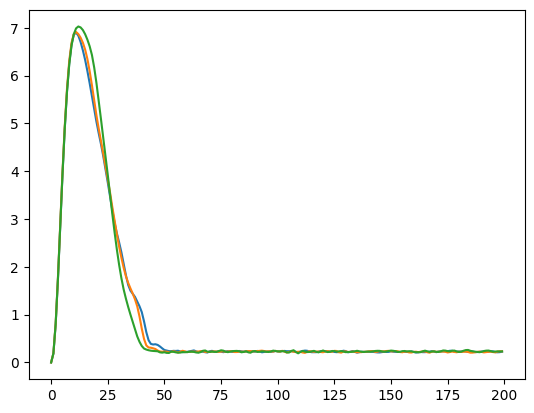

In [214]:
for X in best_unitarity_scores.values():
    plt.plot(X)

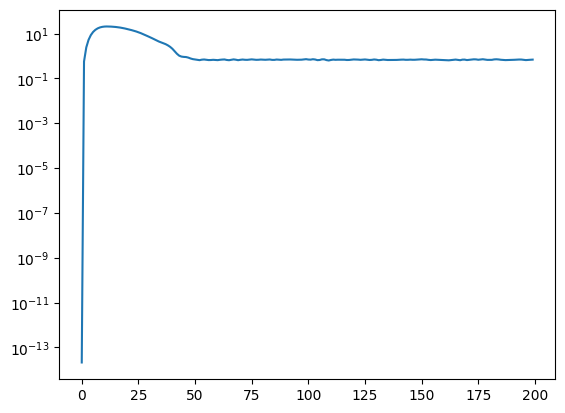

In [215]:
plt.plot(best_overall_unitarity_scores)
plt.yscale('log')

In [216]:
best_overall_unitarity_scores[-1]

0.6910885101038957

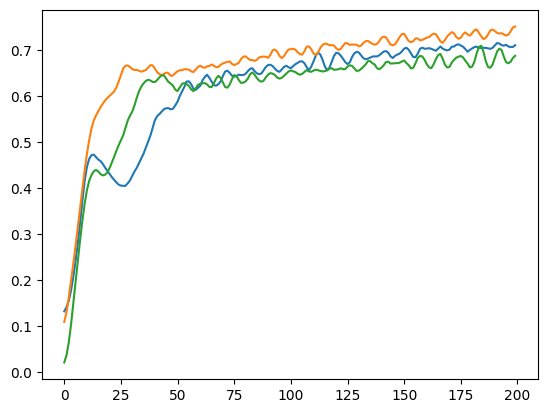

In [217]:
for X in best_overlap_scores.values():
    plt.plot(X)

In [218]:
[v[-1] for v in best_overlap_scores.values()]

[0.7102162551508217, 0.7509228439359226, 0.6871508932434589]

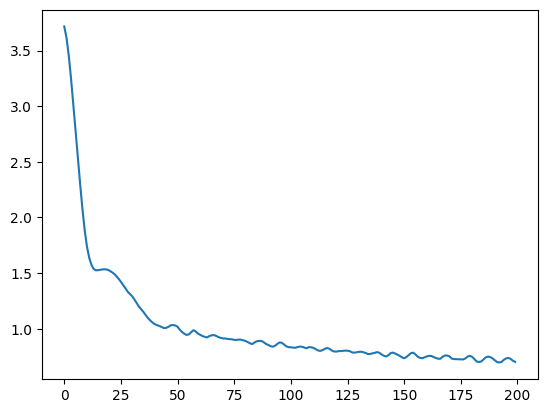

In [219]:
plt.plot(best_overall_target_overlap_scores)

In [220]:
best_overall_target_overlap_scores[-1]

0.7026460970769663

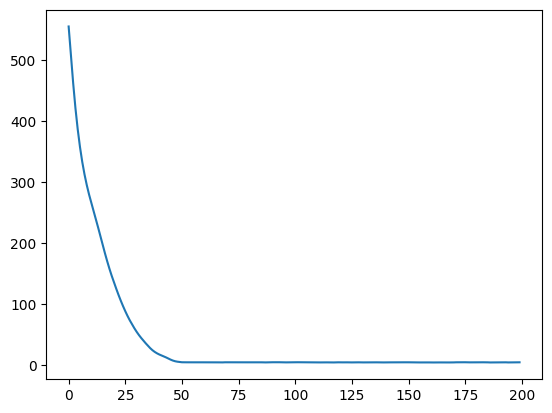

In [221]:
plt.plot(best_proj_rep_scores)

In [222]:
best_proj_rep_scores[-1]

4.346700591962019

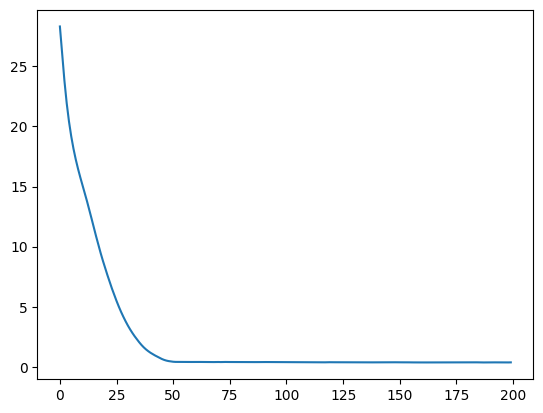

In [223]:
plt.plot(best_cost_function_scores)

In [224]:
best_cost_function_scores[-1]

0.3745635824174381

In [225]:
proj_rep_phases = {
    triple: extract_proj_rep_phase(
        best_solutions_dict,
        triple,
        '(p0.p1.p2.p3.p4)',
        '(p0*.p1*.p2*.p3*.p4*)'
    )
    for triple in group_products
}

In [226]:
phases = [
    get_gauge_invariant_phase(proj_rep_phases, pair)
    for pair in non_trivial_pairs
]

In [227]:
phases

[(-0.9995739875131391+0.0022255453558763837j),
 (-1.0004567557803128-0.0025311112075940075j),
 (-0.9995362767101669-0.0024007919781898544j)]

## B=2.0, 5 sites

In [228]:
num_sites = 5
num_random_initializations = 100
num_gd_iterations = 200

unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

adam_params = (1e-2, 0.3, 0.3)

In [230]:
out = proj_rep_unitary_extraction(cases[20][1:])

In [231]:
(
        best_solutions_dict,
        best_unitarity_scores,
        best_overall_unitarity_scores,
        best_overlap_scores,
        best_overall_target_overlap_scores,
        best_proj_rep_scores,
        best_cost_function_scores
) = out

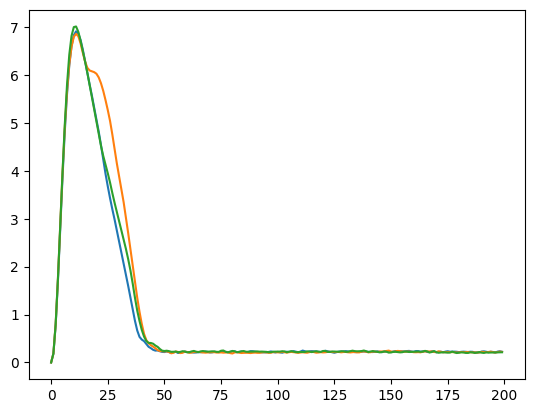

In [232]:
for X in best_unitarity_scores.values():
    plt.plot(X)

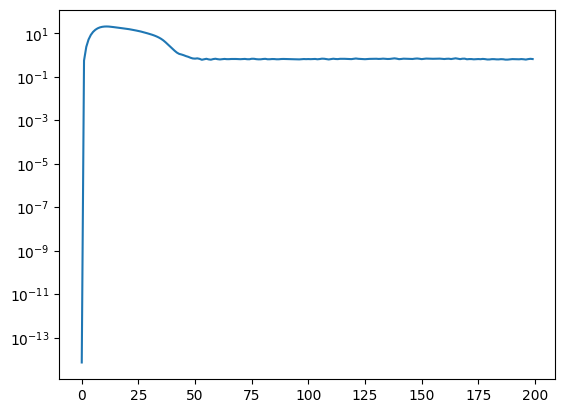

In [233]:
plt.plot(best_overall_unitarity_scores)
plt.yscale('log')

In [234]:
best_overall_unitarity_scores[-1]

0.6574800022833855

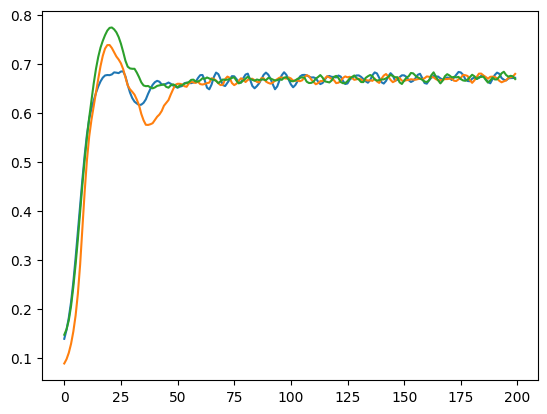

In [235]:
for X in best_overlap_scores.values():
    plt.plot(X)

In [236]:
[v[-1] for v in best_overlap_scores.values()]

[0.6714248324081749, 0.6794731849424885, 0.6688992289386255]

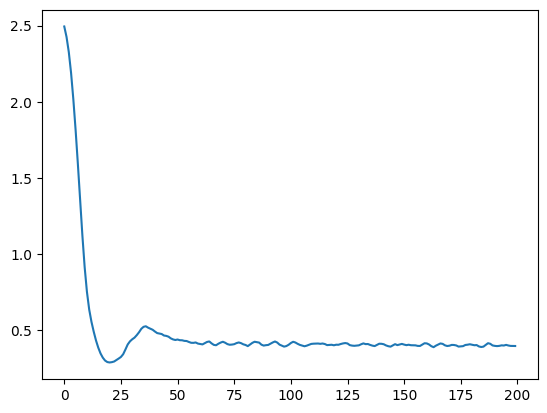

In [237]:
plt.plot(best_overall_target_overlap_scores)

In [238]:
best_overall_target_overlap_scores[-1]

0.39464990051441695

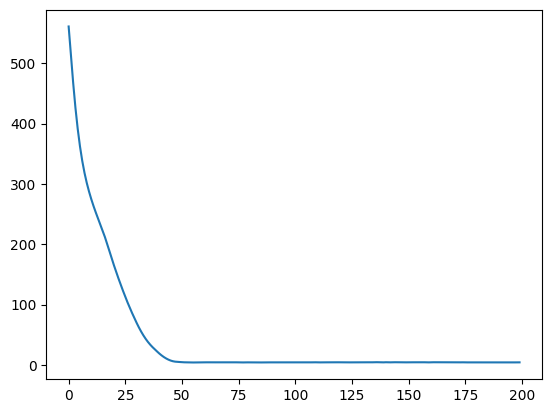

In [239]:
plt.plot(best_proj_rep_scores)

In [240]:
best_proj_rep_scores[-1]

4.042963289505522

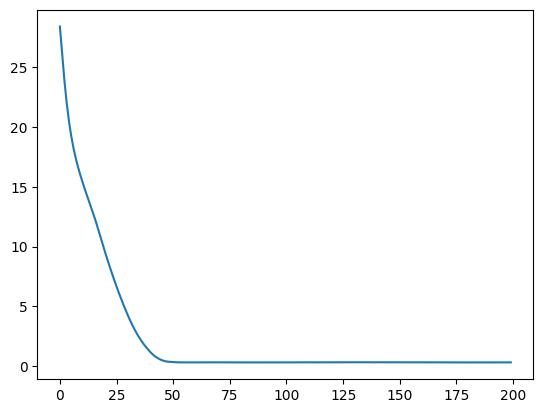

In [241]:
plt.plot(best_cost_function_scores)

In [242]:
best_cost_function_scores[-1]

0.31065664972369256

In [243]:
proj_rep_phases = {
    triple: extract_proj_rep_phase(
        best_solutions_dict,
        triple,
        '(p0.p1.p2.p3.p4)',
        '(p0*.p1*.p2*.p3*.p4*)'
    )
    for triple in group_products
}

In [244]:
phases = [
    get_gauge_invariant_phase(proj_rep_phases, pair)
    for pair in non_trivial_pairs
]

In [245]:
phases

[(-0.9999226556109149+0.0016164207914058297j),
 (-0.9997859503622202-0.001524219270864819j),
 (-1.000258149212731-0.001609284141243052j)]

# Conclusions
* Getting divergences! Not surprising, using the bare unitary cost and the proj rep cost is order 6 in the unitaries! (Roughly).
* Also the convergence is quite noisy, sensitive to hyperparameters.
* Even after converging, can still get the wrong phase! So need to find a very good solution. Could look for bounds on the cost function, but seems like a pain.